## Agent Initiation Tests

Load the environment variables with groq api key
Declare api key as **GROQ_API_KEY** in .env file

In [1]:
from dotenv import load_dotenv
load_dotenv('.env', override=True)

True

In [2]:
from langchain.chat_models import init_chat_model

llm_groq = init_chat_model('groq:llama-3.1-8b-instant',temperature = 0)

In [3]:
result = llm_groq.invoke("Hey what's up!")
print(result.content) # Should print the response from the model

Not much, just here to help with any questions or topics you'd like to discuss. How's your day going so far?


In [4]:
print(result)

content="Not much, just here to help with any questions or topics you'd like to discuss. How's your day going so far?" additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 40, 'total_tokens': 67, 'completion_time': 0.021923437, 'prompt_time': 0.008518083, 'queue_time': 0.454296736, 'total_time': 0.03044152}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None} id='run--c11dc8c0-a96e-4f33-ae6a-b6a23dc50c08-0' usage_metadata={'input_tokens': 40, 'output_tokens': 27, 'total_tokens': 67}


# Tool calling Langchain

In [5]:
from langchain.tools import tool

@tool
def add_numbers(a:int, b:int) -> int:
    """Function to add two numbers"""
    return(a+b)

type(add_numbers)

langchain_core.tools.structured.StructuredTool

In [6]:
add_numbers.args

{'a': {'title': 'A', 'type': 'integer'},
 'b': {'title': 'B', 'type': 'integer'}}

# Tool Binding with Langchain

In [7]:
model_with_tools = llm_groq.bind_tools([add_numbers], tool_choice ="any")
output = model_with_tools.invoke("What is 5 + 2?")
print(output)

content='' additional_kwargs={'tool_calls': [{'id': '9nq4b3n2e', 'function': {'arguments': '{"a":5,"b":2}', 'name': 'add_numbers'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 242, 'total_tokens': 259, 'completion_time': 0.026295997, 'prompt_time': 0.033284724, 'queue_time': 0.218807561, 'total_time': 0.059580721}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--842cdb54-8c46-4bf9-a189-75c2db891fb6-0' tool_calls=[{'name': 'add_numbers', 'args': {'a': 5, 'b': 2}, 'id': '9nq4b3n2e', 'type': 'tool_call'}] usage_metadata={'input_tokens': 242, 'output_tokens': 17, 'total_tokens': 259}


In [8]:
args = output.tool_calls[0]['args']
args

{'a': 5, 'b': 2}

In [9]:
result = add_numbers.invoke(args)
print(result)

7


# LangGraph Function testing/Re-learning

In [10]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict): # Define class of the graph and parameters datatype and co-rellation
    message: str
    
def greeting_node(state: AgentState) -> AgentState:
    """Simple function/node to greet the user"""
    
    state['message'] = "Hey " + state["message"] + " how is your day going?"
    
    return state


In [11]:
graph = StateGraph(AgentState)

graph.add_node("Greeter", greeting_node)

graph.set_entry_point("Greeter")
graph.set_finish_point("Greeter")

app = graph.compile()

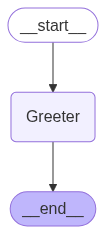

In [12]:
# Remember this as you are gonna use this mermaid function a lot to visualize

from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [13]:
result = app.invoke(AgentState(message="Gideon"))

In [14]:
result["message"]

'Hey Gideon how is your day going?'

# Test 2 (Exercise, Compliment Agent)

In [15]:
from typing import TypedDict, Dict
from langgraph.graph import StateGraph

class StateAgent(TypedDict): # Defining Agent state for carry-forward
    compliments: str
    
def complimenting_node(state:StateAgent) -> StateAgent:
    """ Function to compliment the user """
    state["compliments"] = state["compliments"] + "," + " you're doing an amazing job learning LangGraph!"
    
    return state

graph = StateGraph(StateAgent)

graph.add_node("Complimenter", complimenting_node)

graph.set_entry_point("Complimenter")
graph.set_finish_point("Complimenter")

app = graph.compile()

result = app.invoke(StateAgent(compliments="Gideon"))

print(result["compliments"])

    

Gideon, you're doing an amazing job learning LangGraph!


# Test Graph 3 (Multiple Inputs Graph)

Hi Gideon, your answer is 120


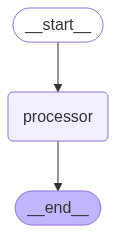

In [16]:
from typing import TypedDict
from langgraph.graph import StateGraph

class MultiInputAgent(TypedDict):
    name:str
    values: list[int]
    operation: str
    result: str
    
def Processor_node(state:MultiInputAgent) -> MultiInputAgent:
    """ Function to process Multiple type of inputs """
    if state["operation"] == "+":
        state["values"] = sum(state["values"])
    elif state["operation"] == "*":
        product = 1
        for value in state["values"]:
            product *= value
        state["values"] = product
        
    state["result"] = "Hi " + state["name"] + ", your answer is " + str(state["values"])
    
    return state

graph = StateGraph(MultiInputAgent)
graph.add_node("processor", Processor_node)
graph.set_entry_point("processor")
graph.set_finish_point("processor")

app = graph.compile()

result = app.invoke(MultiInputAgent(name="Gideon", values = [1,2,3,4,5], operation = "*"))

print(result["result"])

display(Image(app.get_graph().draw_mermaid_png()))

      

# Test Graph 4 (Sequential Graph AKA Join Multiple nodes and States)

In [17]:
from typing import TypedDict, Dict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    name:str
    age:str
    final:str
    
def first_node(state:AgentState) -> AgentState:
    """ First node to attach to the graph"""
    
    state["final"] = f"Hi " + state["name"]
    
    return state

def second_node(state:AgentState) -> AgentState:
    """This is the second node to be attached"""
    
    state["final"] = state["final"] + f" You are " + state["age"] + " years old"
    
    return state

graph = StateGraph(AgentState)
graph.add_node("first_node", first_node)
graph.add_node("second_node", second_node)

graph.set_entry_point("first_node")

# As there are 2 nodes we set an edge
graph.add_edge("first_node", "second_node")
graph.set_finish_point("second_node")
app = graph.compile()

result = app.invoke(AgentState(name="Gideon", age="25"))
print(result)
    

{'name': 'Gideon', 'age': '25', 'final': 'Hi Gideon You are 25 years old'}


# Exercise for Graph 4 (Sequential Graph, Edges, Multiple nodes, Result:str)

In [18]:
from typing import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    name: str
    age: str
    skills : list[str]
    result: str
    
def first_node(state: AgentState) -> AgentState:
    """ First node to attach a greeting"""
    state["result"] = state["name"] + ", welcome to the system!"
    return state

def second_node(state:AgentState) -> AgentState:
    """Attach the user's age"""
    
    state["result"] = state["result"] + " You are " + state["age"] +" years old!"
    return state

def third_node(state:AgentState) -> AgentState:
    """This node appends the user's skills"""
    
    state["result"] = state["result"] + " You have skills in: " + ", ".join(state["skills"]) + "."
    return state

graph = StateGraph(AgentState)

graph.add_node("first_node", first_node)
graph.add_node("second_node", second_node)
graph.add_node("third_node", third_node)

graph.set_entry_point("first_node")
graph.add_edge("first_node", "second_node")
graph.add_edge("second_node", "third_node")
graph.set_finish_point("third_node")

app = graph.compile()


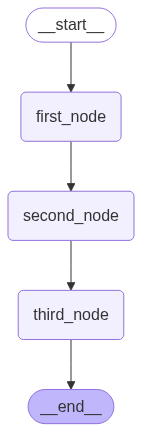

In [19]:
display(Image(app.get_graph().draw_mermaid_png()))

In [20]:
result = app.invoke(AgentState(name="Gideon", age="25", skills=["Python", "Machine Learning", "LangGraph"]))
print(result)

{'name': 'Gideon', 'age': '25', 'skills': ['Python', 'Machine Learning', 'LangGraph'], 'result': 'Gideon, welcome to the system! You are 25 years old! You have skills in: Python, Machine Learning, LangGraph.'}


# Test Graph 5 (Conditional Graphs, Router Node, Start-> End Nodes, Conditional edges)

In [21]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class AgentState(TypedDict):
    number1: int
    number2: int
    operation: str
    finalnumber: int
    
def adder(state:AgentState) -> AgentState:
    """ Function to add 2 numbers"""
    state["finalnumber"] = state["number1"] + state["number2"]
    return state

def subtractor(state:AgentState) -> AgentState:
    """ Function to subtract 2 numbers"""
    state["finalnumber"] = state["number1"] - state["number2"]
    return state  

def decide_node(state:AgentState):
    """Function to decide which operation to perform to act as router"""
    
    if state["operation"] == "+":
        return "addition operation"
    if state["operation"] == "-":
        return "subtraction operation"


graph = StateGraph(AgentState)

# Declare the functions/ nodes to be used in the graph
graph.add_node("router", lambda state:state) # Declaring that router node won't affect the state, and state remains same
graph.add_node("addition", adder)   
graph.add_node("subtraction", subtractor)

# Start mapping the flow using edges

graph.add_edge(START, "router")
graph.add_conditional_edges(
    "router", 
    decide_node,
    {  # Map the return values to the respective nodes              
        "addition operation": "addition",
        "subtraction operation" : "subtraction"   
    }    
)

graph.add_edge("addition", END)
graph.add_edge("subtraction", END)

app = graph.compile()

result = app.invoke(AgentState(number1=10,number2=5, operation="-"))
print(result)


{'number1': 10, 'number2': 5, 'operation': '-', 'finalnumber': 5}


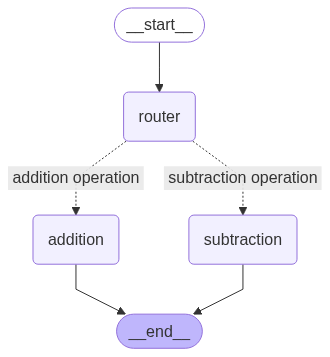

In [22]:
display(Image(app.get_graph(). draw_mermaid_png()))

# Exercise Graph 5 (Double routing Multiple nodes)

In [23]:
# basically create 2 routers for 2 operations

from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class AgentState(TypedDict):
    number1: int
    number2: int
    number3: int
    number4: int
    operation1: str
    operation2: str
    finalnumber1: int
    finalnumber2: int
    
    
def add_node(state:AgentState) -> AgentState:
    """Function to add 2 numbers"""
    state["finalnumber1"] =  state["number1"] + state["number2"]
    return state

def subtract_node(state:AgentState) -> AgentState:
    """ Function to subtract 2 numbers"""
    state["finalnumber1"] = state["number1"] - state["number2"]
    return state  

def add_node2(state:AgentState) -> AgentState:
    """Function to add 2 numbers node 2"""
    state["finalnumber2"] =  state["number3"] + state["number4"]
    return state

def subtract_node2(state:AgentState) -> AgentState:
    """ Function to subtract 2 numbers node 2"""
    state["finalnumber2"] = state["number3"] - state["number4"]
    return state  

def decide_node(state:AgentState):
    """Function to decide which operation to perform to act as router1"""
    
    if state["operation1"] == "+":
        return "addition_operation1"
    if state["operation1"] == "-":
        return "subtraction_operation1"
    
def decide_node2(state:AgentState):
    """Function to decide which operation to perform to act as router2"""
    
    if state["operation2"] == "+":
        return "addition_operation2"
    if state["operation2"] == "-":
        return "subtraction_operation2"
    
graph = StateGraph(AgentState)
graph.add_node("router1", lambda state:state) # Declaring that router node won't affect the state, and state remains same
graph.add_node("router2", lambda state:state) # Declaring that router node won't affect the state, and state remains same
graph.add_node("addition1", add_node)
graph.add_node("addition2", add_node2)
graph.add_node("subtraction1", subtract_node)
graph.add_node("subtraction2", subtract_node2)

# Start mapping the flow using edges
graph.add_edge(START, "router1")
graph.add_conditional_edges(
    "router1",
    decide_node,
    {
        "addition_operation1": "addition1",
        "subtraction_operation1": "subtraction1"
    }
)
graph.add_edge("addition1", "router2")
graph.add_edge("subtraction1", "router2")
graph.add_conditional_edges(
    "router2",
    decide_node2,
    {
        "addition_operation2": "addition2",
        "subtraction_operation2": "subtraction2"
    }
)
graph.add_edge("addition2", END)
graph.add_edge("subtraction2", END)

app = graph.compile()


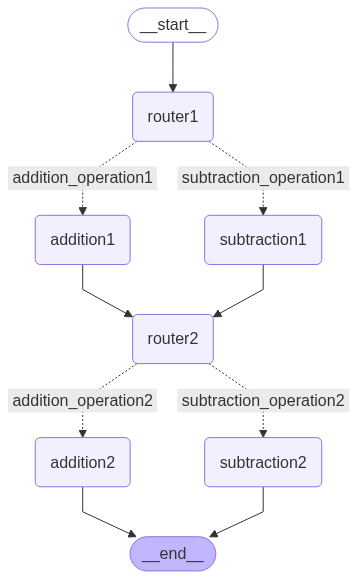

In [24]:
display(Image(app.get_graph().draw_mermaid_png()))

In [25]:
result = app.invoke(AgentState(number1=10, number2=5, number3 =300, number4 =100, operation1= "+", operation2 = "-"))
print(result)

{'number1': 10, 'number2': 5, 'number3': 300, 'number4': 100, 'operation1': '+', 'operation2': '-', 'finalnumber1': 15, 'finalnumber2': 200}


# Final Fundamental test Graph- 6 (Looping Graph)

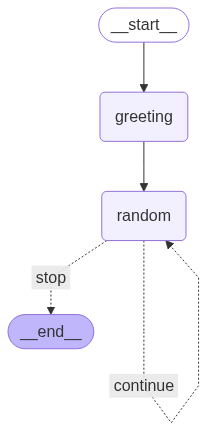

In [26]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
import random

class AgentState(TypedDict):
    name: str
    number: list[int]
    counter:int
    
def greeting_node(state:AgentState) -> AgentState:
    """ Node to greet the user"""
    
    state["name"] = "Hi There," + state["name"] + "!"
    state["counter"] = 0
    
    return state

def random_node(state:AgentState) -> AgentState:
    """ Node to randomly select a number from random function"""
    state["number"].append(random.randint(0,10))
    state["counter"] +=1
    
    return state

def should_continue_node(state:AgentState) -> str:
    """ Node to decide whether to continue or not"""
    
    if state["counter"] < 5:
        print("Counter is less than 5, continuing...")
        return "continue"
    else:
        return "stop"
     
graph = StateGraph(AgentState)

graph.add_node("greeting", greeting_node)
graph.add_node("random", random_node)
graph.add_edge("greeting", "random")

graph.add_conditional_edges(
    "random",
    should_continue_node,
    {
        "continue" : "random", # Self-Loop the node
        "stop": END
    }
)
graph.set_entry_point("greeting")

app = graph.compile()

display(Image(app.get_graph().draw_mermaid_png()))
 

# Exercise 6 (Create a Higher/Lower Guessing Game in Langgraph)

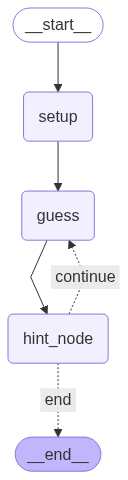

In [27]:
from langgraph.graph import StateGraph, END
import random
from typing import Dict, List, TypedDict

class GameState(TypedDict):
    player_name: str
    target_number: int
    guesses: List[int]
    attempts: int
    hint: str
    lower_bound: int 
    upper_bound: int 
    
def setup_node(state: GameState) -> GameState:
    """Initialize the game with a random target number"""
    state["player_name"] = f"Welcome, {state['player_name']}!"
    state["target_number"] = random.randint(1, 20)
    state["guesses"] = []
    state["attempts"] = 0
    state["hint"] = "Game started! Try to guess the number."
    state["lower_bound"] = 1 
    state["upper_bound"] = 20 
    print(f"{state['player_name']} The game has begun. I'm thinking of a number between 1 and 20.")
    return state

def guess_node(state: GameState) -> GameState:
    """Generate a smarter guess based on previous hints"""
    possible_guesses = []
    
    for i in range(state["lower_bound"], state["upper_bound"] + 1):
        if i in state["guesses"]:
            continue
        else:
            possible_guesses.append(i)
            
    guess = random.choice(possible_guesses)

    
    state["guesses"].append(guess)
    state["attempts"] += 1
    print(f"Attempt {state['attempts']}: Guessing {guess} (Current range: {state['lower_bound']}-{state['upper_bound']})")
    return state

def hint_node(state: GameState) -> GameState:
    """Here we provide a hint based on the last guess and update the bounds"""
    latest_guess = state["guesses"][-1]
    target = state["target_number"]
    
    if latest_guess < target:
        state["hint"] = f"The number {latest_guess} is too low. Try higher!"
        
        state["lower_bound"] = max(state["lower_bound"], latest_guess + 1)
        print(f"Hint: {state['hint']}")
        
    elif latest_guess > target:
        state["hint"] = f"The number {latest_guess} is too high. Try lower!"
      
        state["upper_bound"] = min(state["upper_bound"], latest_guess - 1)
        print(f"Hint: {state['hint']}")
    else:
        state["hint"] = f"Correct! You found the number {target} in {state['attempts']} attempts."
        print(f"Success! {state['hint']}")
    
    return state

def should_continue(state: GameState) -> str:
    """Determine if we should continue guessing or end the game"""
    
    # There are 2 end conditions - either 7 is reached or the correct number is guessed
    
    latest_guess = state["guesses"][-1]
    if latest_guess == state["target_number"]:
        print(f"GAME OVER: Number found!")
        return "end"
    elif state["attempts"] >= 7:
        print(f"GAME OVER: Maximum attempts reached! The number was {state['target_number']}")
        return "end"
    else:
        print(f"CONTINUING: {state['attempts']}/7 attempts used")
        return "continue"
    
graph = StateGraph(GameState)
graph.add_node("setup", setup_node)
graph.add_node("guess", guess_node)
graph.add_node("hint_node", hint_node)  


graph.add_edge("setup", "guess")
graph.add_edge("guess", "hint_node")  


graph.add_conditional_edges(
    "hint_node", 
    should_continue,
    {
        "continue": "guess",
        "end": END
    }
)

graph.set_entry_point("setup")
app = graph.compile()
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [28]:
result = app.invoke(GameState(player_name = "Gideon", Guesses = [], attempts = 0, lower_bound = 1, upper_bound = 20))


Welcome, Gideon! The game has begun. I'm thinking of a number between 1 and 20.
Attempt 1: Guessing 16 (Current range: 1-20)
Hint: The number 16 is too low. Try higher!
CONTINUING: 1/7 attempts used
Attempt 2: Guessing 20 (Current range: 17-20)
Hint: The number 20 is too high. Try lower!
CONTINUING: 2/7 attempts used
Attempt 3: Guessing 19 (Current range: 17-19)
Hint: The number 19 is too high. Try lower!
CONTINUING: 3/7 attempts used
Attempt 4: Guessing 18 (Current range: 17-18)
Hint: The number 18 is too high. Try lower!
CONTINUING: 4/7 attempts used
Attempt 5: Guessing 17 (Current range: 17-17)
Success! Correct! You found the number 17 in 5 attempts.
GAME OVER: Number found!


# Now that the fundamentals are covered for Langgraph lets code out an actual AI Agent

# AI AGENTS!

# Groq Online LLM Test (Llama 8b-Instant via Groq)

In [29]:
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from typing import TypedDict
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END

# Load GROQ_API_KEY from .env file
load_dotenv('.env', override=True)

class AgentState(TypedDict):
    messages: list[HumanMessage]
    
# Define the llm and llm model
llm_groq = init_chat_model('groq:llama-3.1-8b-instant',temperature = 0)

def process(state: AgentState) -> AgentState:
    """Process the messages and generate a response"""
    response = llm_groq.invoke(state["messages"])
    print("AI:", response.content)
    return state

graph = StateGraph(AgentState)
graph.add_node("process", process)
graph.add_edge(START, "process")
graph.add_edge("process", END)

app = graph.compile()

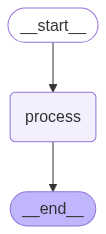

In [30]:
display(Image(app.get_graph().draw_mermaid_png()))

In [31]:
user_input = input("Enter: ")
app.invoke(AgentState(messages=[HumanMessage(content=user_input)]))

AI: What's up?


{'messages': [HumanMessage(content='yo', additional_kwargs={}, response_metadata={})]}

# 2 (Groq Memory Chatbot-Agent) using HumanMessage and AIMessage and simple variables to store context

In [32]:
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from typing import TypedDict, List, Union
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END

# Load GROQ_API_KEY from .env file
load_dotenv('.env', override=True)

class AgentState(TypedDict):
    messages: List[Union[HumanMessage, AIMessage]] # Basically storing Human and AImessage in a list instead of seperate variables

def process(state: AgentState) -> AgentState:
    """Process the messages and generate a response"""
    response = llm_groq.invoke(state["messages"])
    
    state["messages"].append(AIMessage(content=response.content))
    print("AI:", response.content)
    
    return state

graph = StateGraph(AgentState)
graph.add_node("process", process)
graph.add_edge(START, "process")
graph.add_edge("process", END)

app = graph.compile()

conversation_history = []

user_input = input("Enter: ")

while user_input != "exit":
    conversation_history.append(HumanMessage(content=user_input))
    result = app.invoke(AgentState(messages=conversation_history))
    conversation_history = result["messages"]
    user_input = input("Enter: ")
    

AI: It seems like you forgot to ask a question. How can I assist you today?
AI: It seems like you forgot to ask a question. How can I assist you today?
AI: Is there something I can help you with or would you like to chat?
AI: If you're feeling stuck, I can suggest some conversation topics. We could talk about:

 - Hobbies or interests
 - Travel or places you'd like to visit
 - Books or movies you've enjoyed
 - Or something else entirely

Let me know if any of these spark your interest, or feel free to suggest your own topic.


## ReAct Agent  
Industry-standard agent type for **reasoning + acting**.  

## Tools in LangGraph  
How to define and use tools with `ToolNode`.  

## ReAct Graph  
Building a reasoning workflow with `StateGraph`.  

## Message Types  
Work with `BaseMessage`, `ToolMessage`, and `SystemMessage`.  

## System Messages  
Define global context/instructions for agents.  

In [40]:
from typing import TypedDict, Sequence, Annotated
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage # Foundational class for all messages
from langchain_core.messages import ToolMessage # Sends Tool id's and tool content back to the llm
from langchain_core.messages import SystemMessage # Defines the system message of the llm
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

load_dotenv('.env', override=True)

# Reducer function
# Used to merge data from states
# otherwise we overwrite entire state

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    
    
@tool
def add(a:int , b:int):
    """This is an addition function that adds two numbers together"""
    
    return a + b

@tool
def multiply(a:int , b:int):
    """This is a multiplication function that multiplies two numbers together"""
    
    return a * b

tools = [add,multiply]

# initlize llama model
llm_groq = init_chat_model('groq:llama-3.1-8b-instant',temperature = 0)

# Use bind tools to bind tools to the llm
llm_groq.bind_tools(tools)

def model_call(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(content="You are my AI assistant, please answer my query to the best of your ability")
    response = llm_groq.invoke([system_prompt] + state ["messages"])
    return {"messages": [response]}

def should_continue(state: AgentState) -> str:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

    
# initialize graph

graph = StateGraph(AgentState) 
graph.add_node("Gideon_Agent", model_call)

# initialzie Tool node
tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

graph.set_entry_point("Gideon_Agent")

graph.add_conditional_edges(
    "Gideon_Agent",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    },
)
graph.add_edge("tools", "Gideon_Agent")

app = graph.compile()

def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()
            
# bind tools correctly
llm_groq = init_chat_model('groq:llama-3.1-8b-instant', temperature=0)
llm_groq = llm_groq.bind_tools(tools)

# input
from langchain_core.messages import HumanMessage
inputs = {"messages": [HumanMessage(content="Add 700 + 21 and Multiply 100 times 459958")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 700 + 21 and Multiply 100 times 459958
================================== Ai Message ==================================
Tool Calls:
  add (2fmczjmj5)
 Call ID: 2fmczjmj5
  Args:
    a: 700
    b: 21
  multiply (w2k3nqha8)
 Call ID: w2k3nqha8
  Args:
    a: 100
    b: 459958
================================= Tool Message =================================
Name: multiply

45995800
================================== Ai Message ==================================

The results of the addition and multiplication are 721 and 45995800 respectively.


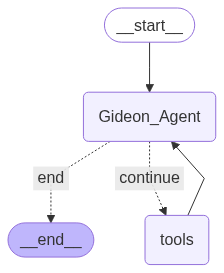

In [37]:
display(Image(app.get_graph().draw_mermaid_png()))